In [1]:
import numpy as np
import os
import random
import torch 
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from TransUNet.networks.vit_seg_modeling import VisionTransformer
from TransUNet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from dataset_function import *
from loss_functions import *
from model_inference_function import *

In [2]:
# this function guarantees reproductivity
def seed_everything(TORCH_SEED):
	random.seed(TORCH_SEED)
	os.environ['PYTHONHASHSEED'] = str(TORCH_SEED)
	np.random.seed(TORCH_SEED)
	torch.manual_seed(TORCH_SEED)
	torch.cuda.manual_seed_all(TORCH_SEED)
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [3]:
seed = 1126
seed_everything(seed)

In [4]:
# Function to set the seed for each worker
def seed_worker(worker_id):
    # Set seed for Python and NumPy in each worker
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [5]:
batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Evaluate model trained on Lits 17 using TCIA dataset

In [6]:
tcia_cases = os.listdir('./tcia_dataset_preprocessed/')

In [7]:
tcia_testing_dataset = TCIADataset(tcia_cases, training = False, use_joint_transforms = False)

In [8]:
print(f'test size: {len(tcia_testing_dataset)}')

test size: 4915


In [9]:
g_test = torch.Generator()
g_test.manual_seed(seed)

In [10]:
tcia_testing_loader = DataLoader(tcia_testing_dataset, batch_size = batch_size, shuffle = False, generator = g_test, worker_init_fn = seed_worker)

In [11]:
config_vit = CONFIGS_ViT_seg["R50-ViT-B_16"]
config_vit.n_classes = 3
config_vit.n_skip = 3
class_weights = [0.1, 1.0, 2.0]
best_model_lits = VisionTransformer(config_vit, img_size = 256, num_classes = config_vit.n_classes).to(device)
checkpoint = torch.load('./model_storage/transunet_weighted/best.pth')
best_model_lits.load_state_dict(checkpoint)
criterion = WeightedCombinedLoss(class_weights = class_weights)

In [12]:
tcia_test_dice_1, tcia_test_dice_2, tcia_test_iou_1, tcia_test_iou_2 = test_model(best_model_lits, tcia_testing_loader, criterion)

  0%|          | 0/154 [00:00<?, ?it/s]

Loss: 0.4691, Dice1: 0.8233, Dice2: 0.8164, IoU1: 0.7452, IoU2: 0.7743


In [35]:
idx = random.randint(0, len(tcia_testing_dataset ))
selected_img, selected_label = tcia_testing_dataset [idx]

In [36]:
pred = infernece(best_model_lits, selected_img)

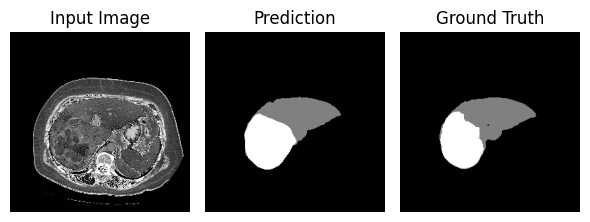

In [37]:
display_result(selected_img, pred, selected_label)

### Evaluate model trained on TCIA dataset using Lits 17

In [16]:
lits_cases = np.arange(131)

In [17]:
lits_testing_dataset = LitsDataset(lits_cases, training = False, use_joint_transforms = False)

In [18]:
print(f'test size: {len(lits_testing_dataset)}')

test size: 19164


In [19]:
g_test = torch.Generator()
g_test.manual_seed(seed + 1)

In [20]:
lits_testing_loader = DataLoader(lits_testing_dataset, batch_size = batch_size, shuffle = False, generator = g_test, worker_init_fn = seed_worker)

In [21]:
config_vit = CONFIGS_ViT_seg["R50-ViT-B_16"]
config_vit.n_classes = 3
config_vit.n_skip = 3
best_model_tcia = VisionTransformer(config_vit, img_size = 256, num_classes = config_vit.n_classes).to(device)
checkpoint = torch.load('./model_storage/transunet_tcia_weighted/best.pth')
best_model_tcia.load_state_dict(checkpoint)
criterion = CombinedLoss()

In [22]:
lits_test_dice_1, lits_test_dice_2, lits_test_iou_1, lits_test_iou_2 = test_model(best_model_tcia, lits_testing_loader, criterion)

  0%|          | 0/599 [00:00<?, ?it/s]

Loss: 0.4167, Dice1: 0.5464, Dice2: 0.3998, IoU1: 0.4376, IoU2: 0.3712


In [23]:
idx = random.randint(0, len(lits_testing_dataset ))
selected_img, selected_label = lits_testing_dataset [idx]

In [24]:
pred = infernece(best_model_tcia, selected_img)

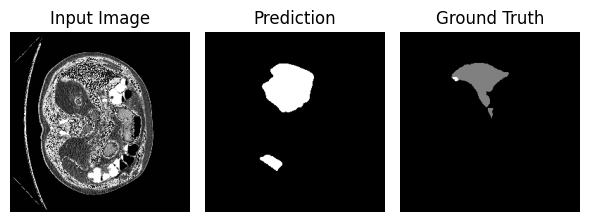

In [25]:
display_result(selected_img, pred, selected_label)